In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import skimage
import numpy as np
from skimage import io
from skimage import color
from scipy import ndimage

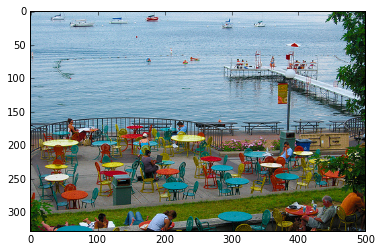

In [31]:
im = io.imread('union-terrace.jpg')
plt.imshow(im)
im = im.astype(float)

In [86]:
def compute_energy(I):
    dx = ndimage.sobel(I, 0)  # horizontal derivative
    dy = ndimage.sobel(I, 1)  # vertical derivative
    mag = np.hypot(dx, dy)  # magnitude
    return mag

In [87]:
def compute_min_energy_array(mag):
    pointers = np.full_like(mag, -1, dtype='int')
    cumenergies = np.zeros_like(mag)

    num_cols = mag.shape[1]
    num_rows = mag.shape[0]

    for c in range(num_cols):
        for r in range(num_rows):
            if c == 0:
                cumenergies[r, c] = mag[r, c]
                continue

            cmp_start = r-1 if r > 0 else 0
            cmp_end   = r+1 if r < num_rows-1 else num_rows-1

            candidates = cumenergies[cmp_start:cmp_end+1, c-1]
            min_energy = np.min(candidates)
            min_pointer = np.argmin(candidates) + cmp_start

            cumenergies[r, c] = min_energy + mag[r, c]
            pointers[r, c] = min_pointer
    
    return cumenergies, pointers

In [88]:
def horizontal_seam(I):
    mag = compute_energy(I)
    cumenergies, pointers = compute_min_energy_array(mag)

    num_cols = I.shape[1]
    seam = np.full((mag.shape[1],), -1, dtype='int')
    prev_col_optimal = np.argmin(cumenergies[:,num_cols-1])

    for c in reversed(range(num_cols)):
        seam[c] = prev_col_optimal
        prev_col_optimal = pointers[prev_col_optimal][c]
    
    return seam

In [89]:
def remove_horizontal_seam(I, S):
    new_img = np.zeros((I.shape[0]-1, I.shape[1]))
    for c in range(S.shape[0]):
        new_img[:,c] = np.delete(I[:,c], S[c])
    return new_img

In [90]:
def shrnk(I, num_rows_removed, num_cols_removed):
    # Remove horizontal seams first.
    cur_img = I
    for r in range(num_rows_removed):
        imgray = color.rgb2gray(cur_img)
        seam = horizontal_seam(imgray)
        shrinked_channels = []
        for channel in range(3):
            shrinked_channels.append(remove_horizontal_seam(cur_img[:,:,channel], seam))
        cur_img = np.stack(shrinked_channels, axis=2)
    
    # Rotate by 90 deg. This is the same as `permute(I, [2 1 3])` in Matlab.
    cur_img = np.transpose(cur_img, (1, 0, 2))
    
    # Remove vertical seams.
    for r in range(num_cols_removed):
        imgray = color.rgb2gray(cur_img)
        seam = horizontal_seam(imgray)
        shrinked_channels = []
        for channel in range(3):
            shrinked_channels.append(remove_horizontal_seam(cur_img[:,:,channel], seam))
        cur_img = np.stack(shrinked_channels, axis=2)
    
    # Rotate back by 90 deg.
    cur_img = np.transpose(cur_img, (1, 0, 2))
    
    return cur_img

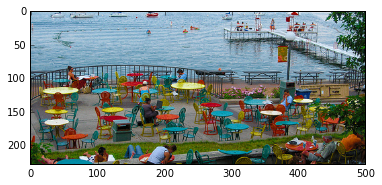

In [94]:
shrnked = shrnk(im, 100, 0)
shrnked = shrnked.astype('uint8')
io.imsave('mudgalsunilk.1a.jpg', shrnked)
plt.imshow(shrnked)

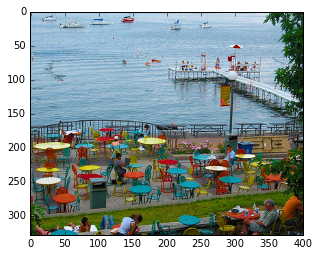

In [95]:
shrnked = shrnk(im, 0, 100)
shrnked = shrnked.astype('uint8')
io.imsave('mudgalsunilk.1b.jpg', shrnked)
plt.imshow(shrnked)

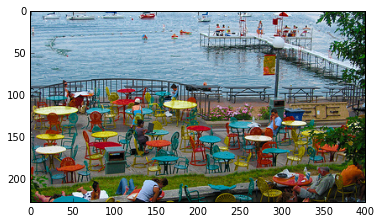

In [96]:
shrnked = shrnk(im, 100, 100)
shrnked = shrnked.astype('uint8')
io.imsave('mudgalsunilk.1c.jpg', shrnked)
plt.imshow(shrnked)

In [69]:
%matplotlib notebook

<IPython.core.display.Javascript object>


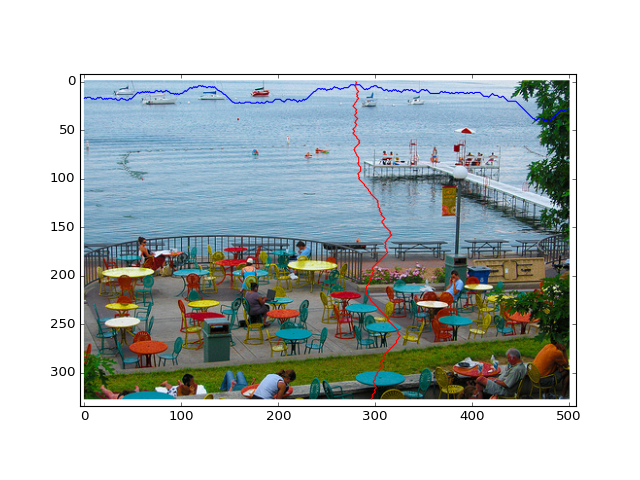

In [70]:
_, hseam, _ = shrnk(im, 1, 0)
_, vseam, _ = shrnk(im, 0, 1)
plt.imshow(im.astype('uint8'))
plt.plot(range(im.shape[1]), hseam)
plt.plot(vseam, range(im.shape[0]), color='r')

In [79]:
%matplotlib inline

In [105]:
grayI = color.rgb2gray(im)
energy = compute_energy(grayI)
min_energy_array, _ = compute_min_energy_array(energy)

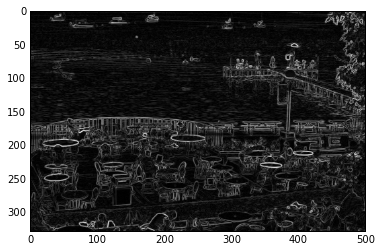

In [106]:
energy = (energy-energy.min()) * 255 / (energy.max() - energy.min())
io.imsave('mudgalsunilk.2a.jpg', energy.astype('uint8'))
plt.imshow(energy.astype('uint8'), cmap='gray')

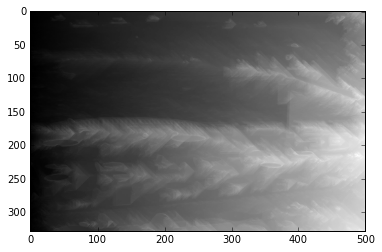

In [107]:
min_energy_array = (min_energy_array-min_energy_array.min()) * 255 / (min_energy_array.max() - min_energy_array.min())
io.imsave('mudgalsunilk.2b.jpg', min_energy_array.astype('uint8'))
plt.imshow(min_energy_array.astype('uint8'), cmap='gray')

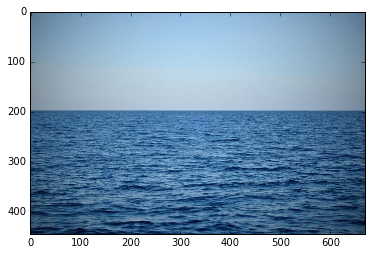

In [97]:
imsea = io.imread('sea.jpg')
plt.imshow(imsea)
imsea = imsea.astype(float)

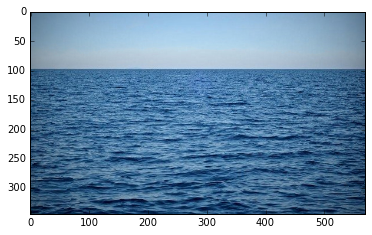

In [98]:
shrnkedsea = shrnk(imsea, 100, 100)
shrnkedsea = shrnkedsea.astype('uint8')
io.imsave('mudgalsunilk.4b.jpg', shrnkedsea)
plt.imshow(shrnkedsea)

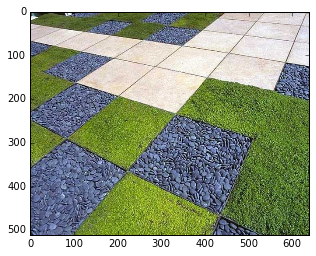

In [101]:
imlandscape = io.imread('landscape.jpg')
plt.imshow(imlandscape)
imlandscape = imlandscape.astype(float)

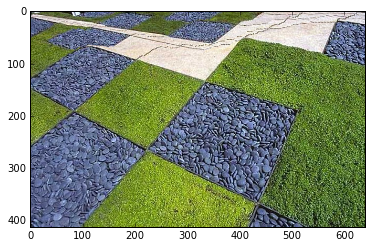

In [104]:
shrnkedlandscape = shrnk(imlandscape, 100, 0)
shrnkedlandscape = shrnkedlandscape.astype('uint8')
io.imsave('mudgalsunilk.5b.jpg', shrnkedlandscape)
plt.imshow(shrnkedlandscape)